In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.size'] = 8
from skimage import img_as_float
from skimage import exposure
import plotly.graph_objects as go

import os
import glob
import random
from skimage import io # To preprocess the images
from distutils.file_util import copy_file
import seaborn as sns
import cv2
import keras
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

from skimage.transform import rescale
from keras_preprocessing.image import ImageDataGenerator

/home/vicky/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/home/vicky/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:293: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  plugin_module = __import__('skimage.io._plugins.' + modname,
2022-04-08 20:44:33.186750: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/

In [2]:
# Set dataset path

DATASET_PATH = './COVID-19_Radiography_Dataset'


cls = ['COVID', 'Normal',"Pneumonia"]

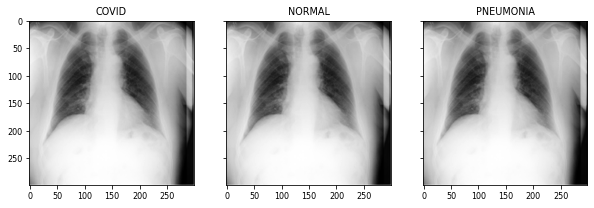

In [3]:
covid_path = os.path.join(DATASET_PATH, cls[0], '*')
covid = glob.glob(covid_path)
covid = io.imread(covid[1])

normal_path = os.path.join(DATASET_PATH, cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[1])

pneumonia_path = os.path.join(DATASET_PATH, cls[2], '*')
pneumonia = glob.glob(pneumonia_path)
pneumonia = io.imread(pneumonia[3])

f, axes = plt.subplots(1, 3, sharey=True)
f.set_figwidth(10)

axes[0].set_title("COVID")
axes[0].imshow(covid, cmap='gray')
axes[1].set_title("NORMAL")
axes[1].imshow(covid, cmap='gray')
axes[2].set_title("PNEUMONIA")
axes[2].imshow(covid, cmap='gray')



In [4]:
print(f'Image shape for COVID dataset is: {covid.shape}')
print(f'Image shape for Normal dataset is: {normal.shape}')
print(f'Image shape for Pneumonia dataset is: {pneumonia.shape}')

Image shape for COVID dataset is: (299, 299)
Image shape for Normal dataset is: (299, 299)
Image shape for Pneumonia dataset is: (299, 299)


In [5]:
print(f'Number of COVID Images: {len(os.listdir(covid_path[:-2]))} \
\nNumber of Normal Images: {len(os.listdir(normal_path[:-2]))}\nNumber of Pneumonia Images: {len(os.listdir(pneumonia_path[:-2]))}')

Number of COVID Images: 3616 
Number of Normal Images: 10192
Number of Pneumonia Images: 1345


In [6]:
# Histogram Equalization

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

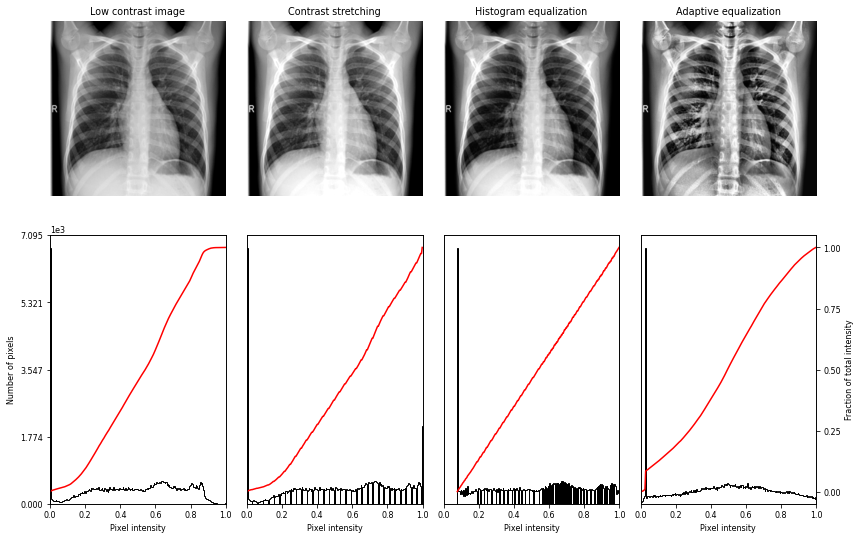

In [7]:
# Load a normal image
img = normal

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(12, 8))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()


In [ ]:
CLASSES = ["COVID",  "Normal","Pneumonia"]
#Image augmentation process:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = False,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    brightness_range=[0.5,2.0],
    height_shift_range = 0.2,
    fill_mode = 'nearest',
    
    #split dataset to training(80%) and validation(20%):
    validation_split = 0.2
)

In [ ]:
CLASSES = ["COVID",  "Normal","Pneumonia"]
train = train_datagen.flow_from_directory(
    directory=DATASET_PATH,
    target_size=(299, 299),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='training',
    classes=CLASSES
)
val = train_datagen.flow_from_directory(
    directory=DATASET_PATH,
    target_size=(299, 299),
    batch_size=32,
    shuffle=True,
    class_mode='categorical',
    subset='validation',
    classes=CLASSES
)

Found 12123 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.


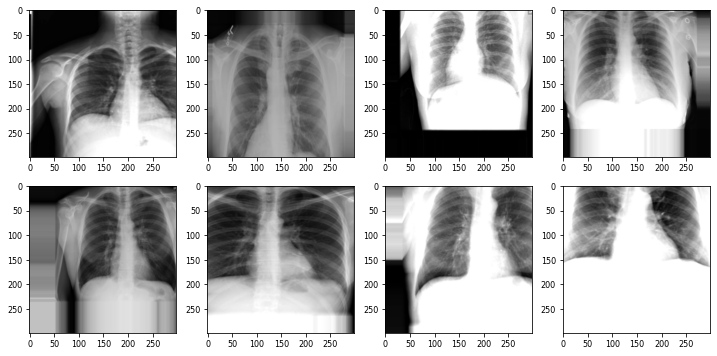

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(8):
    img, label = train.next()
    plt.subplot(2, 4, i + 1)
    plt.imshow(img[0])

plt.tight_layout()

In [34]:
CLASSES = ["COVID",  "Normal"]
train_data = train_datagen.flow_from_directory(
    directory=DATASET_PATH,
    target_size=(299, 299),
    batch_size=16,
    shuffle=True,
    class_mode='binary',
    subset='training',
    classes=CLASSES
    )
val_data = train_datagen.flow_from_directory(
    directory=DATASET_PATH,
    target_size=(299, 299),
    batch_size=16,
    shuffle=True,
    class_mode='binary',
    subset='validation',
    classes=CLASSES
    )

Found 11047 images belonging to 2 classes.
Found 2761 images belonging to 2 classes.


In [35]:
# Define the Keras model
# Use InceptionResNetV2 Keras model

engine = tf.keras.applications.InceptionResNetV2(
    # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
    include_top = False,

    # Use Imagenet weights
    weights = 'imagenet',

    # Define input shape to 224x224x3
    input_shape = (224, 224, 3),

    # Set classifier activation to sigmoid
    classifier_activation = 'sigmoid'
)

In [36]:
# Define the Keras model outputs

x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(engine.output)
out = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'dense_output')(x)


# Build the Keras model

model = tf.keras.models.Model(inputs = engine.input, outputs = out)

In [37]:
# Define our custom loss function

def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [38]:
# Compile our model

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=[focal_loss], metrics=["accuracy"], optimizer=adam)

In [ ]:
# Fit Keras model
start = datetime.datetime.now()

history = model.fit(
    # Use train generator
    train_data,

    # Set epochs to 20
    epochs = 20,

    # Set steps per epochs to 300
    steps_per_epoch = 300,       # batch_size

    # Set verbose to 1
    verbose = 1
)

end = datetime.datetime.now()
print(f'Total Training Time: {end - start}')

In [ ]:
# Check the accuracy of the Keras model on the test data

testLoss, testAccuracy = model.evaluate(
    # Use test generator
    val_data,
    
    # Set verbose to 1
    verbose = 1
)

# Print results
print('Accuracy of model : ' + str(round(testAccuracy,4)*100) + ' %')
print('Loss of model : ' + str(round(testLoss,4)))